# 506 group project

This script is completed by Xinyang Qi.

Firstly, import package and read data.

In [194]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from patsy import dmatrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

In [168]:
data1=pd.read_sas('ALQ_D.xpt')
data2=pd.read_sas('PAQ_D.xpt')
data3=pd.read_sas('PAQIAF_D.xpt')
data4=pd.read_sas('SLQ_D.xpt')
data5=pd.read_sas('DR1TOT_D.xpt')
data6=pd.read_sas('DEMO_D.xpt')

Then, extract and clean data.

In [169]:
data1=data1[['SEQN','ALQ130']]
data2=data2[['SEQN','PAQ520']]
data4=data4[['SEQN','SLD010H']]
data3=data3[['SEQN','PADTIMES','PADDURAT']]
data5=data5[['SEQN','DR1TKCAL','DR1TSUGR','DR1TCAFF']]
data6=data6[['SEQN','RIAGENDR','RIDAGEYR','RIDRETH1','INDFMINC','RIDEXMON']]

In [170]:
data=pd.merge(data1,data2,on='SEQN',how='inner')
data=pd.merge(data,data3,on='SEQN',how='inner')
data=pd.merge(data,data4,on='SEQN',how='inner')
data=pd.merge(data,data5,on='SEQN',how='inner')
data=pd.merge(data,data6,on='SEQN',how='inner')

In [171]:
data=data[data.PAQ520 != 9]
data=data[data.PAQ520 != 7]
data=data[data.SLD010H != 77]
data=data[data.SLD010H != 99]
data=data[data.INDFMINC < 12]
data=data[data.ALQ130<800]
data=data.dropna()
data=data.groupby('SEQN').mean()

In [172]:
data.columns=['alcohol','act_level','act_times','act_durat','sleep_time','energy','sugars','caffeine','gender','age','race','inc','winter']

In [173]:
data['gender']=data['gender']-1
data['Mex']=1*(data['race']==1)
data['Hisp']=1*(data['race']==2)
data['NHwhite']=1*(data['race']==3)
data['NHblack']=1*(data['race']==4)
data['pa_high']=1*(data['act_level']==1)
data['pa_low']=1*(data['act_level']==2)
data['winter']=1*(data['winter']==1)
data['pad']=data['act_times']*data['act_durat']/60
data=data.drop(['act_level','act_times','act_durat','race'],axis=1)

In [174]:
data['gender']=data['gender'].apply(str)
data['Mex']=data['Mex'].apply(str)
data['Hisp']=data['Hisp'].apply(str)
data['NHwhite']=data['NHwhite'].apply(str)
data['NHblack']=data['NHblack'].apply(str)
data['pa_high']=data['pa_high'].apply(str)
data['pa_low']=data['pa_low'].apply(str)
data['winter']=data['winter'].apply(str)
data1 = data._get_numeric_data()

# Part 1
Firstly, we create a model with all predictors in order to find the effect of activity time and other factors on sleep time.

In [181]:
mod1 = smf.ols(formula='sleep_time ~ alcohol+energy+sugars+caffeine+gender+age+inc+winter+Mex+Hisp+NHwhite+NHblack+pa_high+pa_low+pad', data=data)
res1 = mod1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:             sleep_time   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     7.074
Date:                Wed, 11 Dec 2019   Prob (F-statistic):           2.95e-15
Time:                        13:17:05   Log-Likelihood:                -2864.5
No. Observations:                1769   AIC:                             5761.
Df Residuals:                    1753   BIC:                             5849.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.8244      0.226     30.208

Then, in order to improve the model, we select variables based on their vif and Covariance matrix at first. Then, using backward elimination to select variables.

In [182]:
# In order to improve the model, we select variables based on their vif and Covariance matrix at first. 
# Then, using backward elimination to select variables.
# get y and X dataframes based on this regression:
y, X = dmatrices('sleep_time ~ alcohol + pad + energy + sugars + caffeine + age + inc', data, return_type='dataframe')

In [183]:
# Calculate VIF
vif=pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"]=X.columns

In [184]:
print(vif)

   VIF Factor   features
0   26.656996  Intercept
1    1.182127    alcohol
2    1.022109        pad
3    1.740432     energy
4    1.633650     sugars
5    1.039183   caffeine
6    1.139216        age
7    1.044989        inc


In [185]:
# Calculate covariance matrix
data1.drop('sleep_time',axis=1).corr()

,alcohol,energy,sugars,caffeine,age,inc,pad
alcohol,1.000000,0.253594,0.075544,-0.020018,-0.273134,-0.158324,0.066287
energy,0.253594,1.000000,0.607588,0.089986,-0.190953,-0.036463,0.047701
sugars,0.075544,0.607588,1.000000,0.035082,-0.159947,-0.079295,-0.024843
caffeine,-0.020018,0.089986,0.035082,1.000000,0.140236,0.055436,-0.019543
age,-0.273134,-0.190953,-0.159947,0.140236,1.000000,0.034634,0.042077
inc,-0.158324,-0.036463,-0.079295,0.055436,0.034634,1.000000,-0.091718
pad,0.066287,0.047701,-0.024843,-0.019543,0.042077,-0.091718,1.000000


Create an OLS regression model based on a subset.

In [186]:
mod2 = smf.ols(formula='sleep_time ~ C(Mex)+C(NHwhite)+C(NHblack)+C(pa_low)+age+alcohol+pad+sugars+caffeine',data=data).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sleep_time   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     11.48
Date:                Wed, 11 Dec 2019   Prob (F-statistic):           1.18e-17
Time:                        13:17:40   Log-Likelihood:                -2866.0
No. Observations:                1769   AIC:                             5752.
Df Residuals:                    1759   BIC:                             5807.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.8008      0.150     45.200      0.000       6.506       7.096
C(Mex)[T.1]         0.2624      0.137      1.921      0.055      -0.005       0.530
C(NHwhite)[T.1]     0.3811      0.118      3.217      0.001       0.149       0.613
C(NHblack)[T.1]    -0.2716      0.132     -2.058      0.040      -0.531      -0.013
C(pa_low)[T.1]      0.1448      0.078      1.855      0.064      -0.008       0.298
age                 0.0033      0.002      1.777      0.076      -0.000       0.007
alcohol            -0.0315      0.012     -2.611      0.009      -0.055      -0.008
pad                -0.0025      0.002     -1.504      0.133      -0.006       0.001
sugars             -0.0006      0.000     -1.662      0.097      -0.001       0.000
caffeine           -0.0007      0.000     -4.709      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       52.889   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.480
Skew:                          -0.241   Prob(JB):                     1.37e-20
Kurtosis:                       4.004   Cond. No.                     2.21e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the summary above, we find that compared with other predictors, the effect of activity time is not very significant.

# Part 2

secondly, we will create model to analyse the relationship between activity time and sleep time. 

In [187]:
mod3 = smf.ols(formula='sleep_time ~ pad',data = data).fit()
mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sleep_time   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.597
Date:                Wed, 11 Dec 2019   Prob (F-statistic):              0.107
Time:                        13:22:43   Log-Likelihood:                -2915.2
No. Observations:                1769   AIC:                             5834.
Df Residuals:                    1767   BIC:                             5845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9109      0.035    199.931      0.000       6.843       6.979
pad           -0.0027      0.002     -1.612      0.107      -0.006       0.001
==============================================================================
Omnibus:                       61.688   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.840
Skew:                          -0.333   Prob(JB):                     1.88e-20
Kurtosis:                       3.888   Cond. No.                         23.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

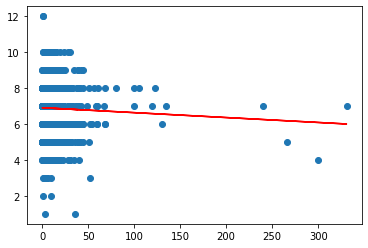

In [188]:
plt.scatter(data.pad,data.sleep_time)
plt.plot(data.pad,mod3.predict(),color = 'red')
plt.show()

From the graph above, we find that although the fitted line has a curvature, it is not convincing.

Because alcohol data is not available for respondents age under 20, we try to create model with full dataset.

And because reported sleep should be an approximate value, we will give each sleep time a random disturbance to let 'sleep time' become a continuous variable. 

In [189]:
data_pad = pd.merge(data3,data4,on='SEQN',how='inner')
data_pad = data_pad[data_pad.SLD010H != 77]
data_pad = data_pad[data_pad.SLD010H != 99]
data_pad = data_pad.dropna()
data_pad = data_pad.groupby('SEQN').mean()
data_pad['pad']=data_pad['PADTIMES']*data_pad['PADDURAT']/60
data_pad = data_pad.drop(['PADTIMES','PADDURAT'],axis=1)
data_pad.columns = ['sleep_time','pad']

In [190]:
eps = np.random.normal(0,0.2,size = data_pad.shape[0])

In [191]:
data_pad['sleep_time']=data_pad['sleep_time']+eps

In [192]:
mod6 = smf.ols(formula='sleep_time ~ pad',data = data_pad).fit()
mod6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sleep_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5820
Date:                Wed, 11 Dec 2019   Prob (F-statistic):              0.446
Time:                        13:38:04   Log-Likelihood:                -6856.8
No. Observations:                3946   AIC:                         1.372e+04
Df Residuals:                    3944   BIC:                         1.373e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0083      0.026    267.352      0.000       6.957       7.060
pad           -0.0010      0.001     -0.763      0.446      -0.004       0.002
==============================================================================
Omnibus:                       79.616   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.708
Skew:                          -0.099   Prob(JB):                     9.36e-35
Kurtosis:                       3.956   Cond. No.                         23.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

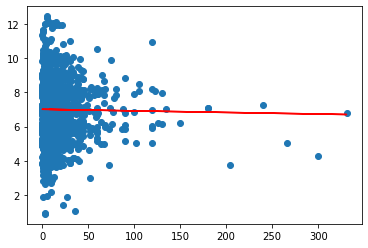

In [193]:
plt.scatter(data_pad.pad,data_pad.sleep_time)
plt.plot(data_pad.pad,mod5.predict(),color = 'red')
plt.show()

From the summary, we can find that activity time still have very little effect on sleep time. 

Maybe the activity time does not have a linear relationship with sleep time. So we decide to use spline regression to try to improve its fit.

In [154]:
transformed_x1 = dmatrix("bs(data_pad.pad, df=3, degree = 3, include_intercept=False)",
                        {"data_pad.pad": data_pad.pad}, return_type='dataframe')

In [155]:
mod7 = sm.GLM(data_pad.sleep_time, transformed_x1).fit()
print(mod7.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             sleep_time   No. Observations:                 3946
Model:                            GLM   Df Residuals:                     3942
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1.8838
Method:                          IRLS   Log-Likelihood:                -6846.6
Date:                Wed, 11 Dec 2019   Deviance:                       7425.8
Time:                        12:54:33   Pearson chi2:                 7.43e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

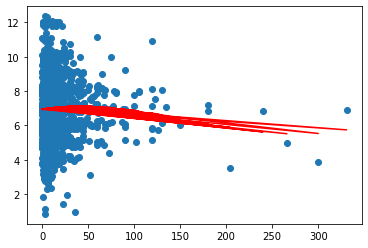

In [156]:
plt.scatter(data_pad.pad,data_pad.sleep_time)
plt.plot(data_pad.pad,mod7.predict(),color = 'red')
plt.show()

Based on the summary and graph above, although the spline regression improve the fit slightly, the relationship between sleep time and activity time is still not strong.

Base on all the analyse above, although all models have a weak trend that people who do activity for longer time tend to sleep less, we have to conclude that compared with the effect of alcohol and caffeine on sleep time, the effect of activity time is much little.